In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import json
import torch

from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

from pnr_utils import *
from pnr_models import *

seed = 12
torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

In [12]:
# to reload modules without restarting kernel (optional)
from importlib import reload
import sys
reload(sys.modules['pnr_utils'])
reload(sys.modules['pnr_models'])
from pnr_utils import *
from pnr_models import *

### Load and process synthetic data

- Input the **sample name** and the **set number** of the dataset generated by `pnr_generate.py` to locate the appropriate directories and read the metadata.


- Load and process (apply noise, smoothing, and normalization to) spectra and identify the parameter names (y_header) and corresponding indices (y_ids) to use for supervised learning.


- Standardize y-data (parameter values), perform train/valid/test split stratified by class, and convert data to torch tensors.

In [3]:
# set data properties
sample_name = 'BiSe10_EuS5' #'CrO20_BiSbTe20'
dataset = 4
fit_roughness = False

# get directories
set_dir = 'results/' + sample_name + '/set_' + str(dataset)
data_dir = set_dir + '/data'

# parse metadata and experiment files
layers, rho, M, N, q_min, q_max = parse_metadata(set_dir)
q = 10*np.linspace(q_min, q_max, N)
exp_names = next(os.walk('experiments/' + sample_name))[1]
exp_names = [k for k in exp_names if '-' not in k]
exp_names = [sample_name + '/' + exp_names[j] for j in np.argsort([int(i[:i.index('K')]) for i in exp_names])]

print('set directory:', set_dir)

set directory: results/BiSe10_EuS5/set_4


In [4]:
# load and process data
x_data, x_orig, x_moms, y_data, y_columns, y_header, y_ids, y_labels, y_units = process_data(data_dir, sample_name,
                                                                                             exp_names[0], q, seed,
                                                                                             fit_roughness)

# split data
x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(x_data, y_data, seed)

train size: 67000 positive examples: 33403 negative examples: 33597
valid size: 16500 positive examples: 8226 negative examples: 8274
test size: 16500 positive examples: 8226 negative examples: 8274


In [5]:
# standardize data
scaler = StandardScaler().fit(y_train[:,y_ids[:-1]])
torch_scaler = TorchStandardScaler()
torch_scaler.mean = torch.tensor(scaler.mean_).to(device)
torch_scaler.std = torch.tensor(np.sqrt(scaler.var_)).to(device)

y_train[:,np.array(y_ids[:-1])] = scaler.transform(y_train[:,y_ids[:-1]])
y_valid[:,np.array(y_ids[:-1])] = scaler.transform(y_valid[:,y_ids[:-1]])
y_test[:,np.array(y_ids[:-1])] = scaler.transform(y_test[:,y_ids[:-1]])

In [6]:
# convert to torch tensors
x_train = torch.from_numpy(x_train).unsqueeze(1)
x_valid = torch.from_numpy(x_valid).unsqueeze(1)
x_test = torch.from_numpy(x_test).unsqueeze(1)
y_train = torch.from_numpy(y_train)
y_valid = torch.from_numpy(y_valid)
y_test = torch.from_numpy(y_test)

height = x_train.size()[2]
width = x_train.size()[3]
num_features = len(y_ids) - 1
print('height:', height, 'width:', width, 'num_features:', num_features)

height: 256 width: 2 num_features: 10


### Define model

- Input the **model name** (vae, cvae, rvae) for the model to train according to:
    * vae: simple VAE with no classifier or regressors
    * cvae: VAE + classifier
    * rvae: CVAE + regressors for each parameter value


- Input the **model number** to resume training (or to continue analysis without further fitting), or -1 to start a new fit.


- Input the number of models (**reps**) to train in succession, and set the **batch size** and number of **epochs**.


- Set **z_std_norm** to False if z_mean is presumed to match the parameter values, or True if presumed to be 0, and set the parameters defining the model architecture.

In [7]:
# model to train
model_name = 'rvae'
model_num = -1           # -1 to start a new fit, model number to resume or analyze

# training parameters
reps = 1
batch_size = 256
epochs = 60

# model parameters
z_std_norm = False       # True if z ~ N(0,1), False if z ~ N(mu,1), mu > 0
kwargs = {
    'hidden_dim': 512,
    'latent_dim': 24,
    'start_filters': 16,
    'kernel_size': 7,
    'pool_size': 4,
    'num_conv': 2,
    'num_dense': 5,
    'slope': 0.3,
    'drop': False,
    'beta_1': 0.01,
    'beta_2': 0.01
}

In [8]:
# print model architecture
model, _, _ = init_model(model_name, height, width, num_features, kwargs, device, scaler=torch_scaler)
print(model)

print('number of parameters:', sum([p.numel() for p in model.parameters() if p.requires_grad]))

RVAE(
  (encoder_conv): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(7, 1), stride=(4, 1), padding=(2, 0))
      (1): LeakyReLU(negative_slope=0.3)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(7, 1), stride=(4, 1), padding=(2, 0))
      (1): LeakyReLU(negative_slope=0.3)
    )
  )
  (encoder_fc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.3)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.3)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.3)
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.3)
    )
    (4): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): LeakyReLU(negative_sl

In [9]:
# set model directories
model_prefix = '/' + model_name + '_'
resume_fit = model_num >= 0

if resume_fit:
    # load args from saved model directory
    model_dir = set_dir + model_prefix + str(model_num)
    args = torch.load(model_dir + '/model_0/model.torch')['args']
    start_epoch = args['epochs']
    epochs = start_epoch + epochs
    args['epochs'] = epochs
    
    kwargs = args['kwargs']
    
else:
    # create new model directory
    args = {}
    dirs = next(os.walk(set_dir))[1]
    for k in dirs:
        if k.startswith('.'): dirs.remove(k)
    dirs.remove('data')
    if 'properties' in dirs: dirs.remove('properties')

    if len(dirs):
        idns = [int(d.split('_')[-1]) for d in dirs]
        idn = max(idns) + 1
        args['model_num'] = idn
        model_dir = set_dir + model_prefix + str(idn)
    else:
        args['model_num'] = 0
        model_dir = set_dir + model_prefix + '0'

    os.makedirs(model_dir)
    start_epoch = 0
    
    # save arguments
    args['batch_size'] = batch_size
    args['reps'] = reps
    args['epochs'] = epochs
    args['z_std_norm'] = z_std_norm
    args['kwargs'] = kwargs.copy()
    
meta = json.dumps(args, sort_keys=True, indent=2)
with open(model_dir + '/args.txt', 'w') as f:
    f.write(meta)

print('model directory:', model_dir)

model directory: results/BiSe10_EuS5/set_4/rvae_0


In [10]:
# configure data loaders
data_train = TensorDataset(x_train, y_train)
data_valid = TensorDataset(x_valid, y_valid)
data_test = TensorDataset(x_test, y_test)

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=batch_size)
test_loader = DataLoader(data_test, batch_size=batch_size)

d_sets = ['train', 'valid', 'test']
data_loaders = dict(zip(d_sets, [DataLoader(data_train, batch_size=batch_size), valid_loader, test_loader]))

### Train model

- Train reps number of models in succession.

In [ ]:
for r in range(reps):
    image_dir = model_dir + '/model_' + str(r)
    if not os.path.exists(image_dir): os.makedirs(image_dir)

    model, opt, metric_keys = init_model(model_name, height, width, num_features, kwargs, device, scaler=torch_scaler)

    print('====== repetition:', r)

    if resume_fit:
        model.load_state_dict(torch.load(image_dir + '/model.torch')['state'])
        opt.load_state_dict(torch.load(image_dir + '/model.torch')['optimizer'])
        dynamics = torch.load(image_dir + '/model.torch')['dynamics']
    else: dynamics = []

    for epoch in range(start_epoch + 1, epochs + 1):
        train_metrics = train(epoch, model, opt, metric_keys, train_loader, device, model_name, z_std_norm, y_ids) 
        valid_metrics = evaluate(epoch, model, metric_keys, valid_loader, device, model_name, z_std_norm, y_ids)
        dynamics.append({
            'epoch': epoch,
            'train': train_metrics,
            'valid': valid_metrics
        })

    results = {
        'args': args,
        'dynamics': dynamics,
        'state': model.state_dict(),
        'optimizer': opt.state_dict()
    }

    # save data and metadata to .torch dictionary
    with open(image_dir + '/model.torch', 'wb') as f:
        torch.save(results, f)

====== repetition: 0
epoch: 1 train =====   total_loss: 3.00e+00   recon_loss: 2.84e+00   kld_loss: 6.54e+00   label_loss: 1.01e+01   recon_mse: 5.54e-03   label_mse: 1.01e+00
epoch: 1 valid =====   total_loss: 2.02e+00   recon_loss: 1.87e+00   kld_loss: 5.11e+00   label_loss: 1.00e+01   recon_mse: 3.66e-03   label_mse: 1.00e+00
epoch: 2 train =====   total_loss: 2.02e+00   recon_loss: 1.87e+00   kld_loss: 5.07e+00   label_loss: 1.00e+01   recon_mse: 3.66e-03   label_mse: 1.00e+00
epoch: 2 valid =====   total_loss: 2.02e+00   recon_loss: 1.87e+00   kld_loss: 5.04e+00   label_loss: 1.00e+01   recon_mse: 3.66e-03   label_mse: 1.00e+00
epoch: 3 train =====   total_loss: 2.02e+00   recon_loss: 1.87e+00   kld_loss: 5.02e+00   label_loss: 1.00e+01   recon_mse: 3.66e-03   label_mse: 1.00e+00
epoch: 3 valid =====   total_loss: 2.02e+00   recon_loss: 1.87e+00   kld_loss: 5.01e+00   label_loss: 1.00e+01   recon_mse: 3.66e-03   label_mse: 1.00e+00
epoch: 4 train =====   total_loss: 2.02e+00   rec

epoch: 27 valid =====   total_loss: 2.49e-01   recon_loss: 8.88e-02   kld_loss: 1.21e+01   label_loss: 3.88e+00   recon_mse: 1.73e-04   label_mse: 3.88e-01
epoch: 28 train =====   total_loss: 2.75e-01   recon_loss: 1.17e-01   kld_loss: 1.19e+01   label_loss: 3.87e+00   recon_mse: 2.29e-04   label_mse: 3.87e-01
epoch: 28 valid =====   total_loss: 2.50e-01   recon_loss: 9.29e-02   kld_loss: 1.19e+01   label_loss: 3.84e+00   recon_mse: 1.82e-04   label_mse: 3.84e-01
epoch: 29 train =====   total_loss: 2.72e-01   recon_loss: 1.15e-01   kld_loss: 1.19e+01   label_loss: 3.83e+00   recon_mse: 2.24e-04   label_mse: 3.83e-01
epoch: 29 valid =====   total_loss: 2.35e-01   recon_loss: 7.91e-02   kld_loss: 1.18e+01   label_loss: 3.77e+00   recon_mse: 1.54e-04   label_mse: 3.77e-01
epoch: 30 train =====   total_loss: 2.69e-01   recon_loss: 1.13e-01   kld_loss: 1.18e+01   label_loss: 3.78e+00   recon_mse: 2.20e-04   label_mse: 3.78e-01
epoch: 30 valid =====   total_loss: 2.37e-01   recon_loss: 8.00e

epoch: 54 train =====   total_loss: 2.30e-01   recon_loss: 9.23e-02   kld_loss: 1.13e+01   label_loss: 2.52e+00   recon_mse: 1.80e-04   label_mse: 2.52e-01
epoch: 54 valid =====   total_loss: 2.00e-01   recon_loss: 6.07e-02   kld_loss: 1.13e+01   label_loss: 2.66e+00   recon_mse: 1.18e-04   label_mse: 2.66e-01
epoch: 55 train =====   total_loss: 2.30e-01   recon_loss: 9.26e-02   kld_loss: 1.12e+01   label_loss: 2.50e+00   recon_mse: 1.81e-04   label_mse: 2.50e-01
epoch: 55 valid =====   total_loss: 1.98e-01   recon_loss: 5.98e-02   kld_loss: 1.12e+01   label_loss: 2.61e+00   recon_mse: 1.17e-04   label_mse: 2.61e-01
epoch: 56 train =====   total_loss: 2.29e-01   recon_loss: 9.23e-02   kld_loss: 1.12e+01   label_loss: 2.46e+00   recon_mse: 1.80e-04   label_mse: 2.46e-01
epoch: 56 valid =====   total_loss: 1.99e-01   recon_loss: 6.09e-02   kld_loss: 1.13e+01   label_loss: 2.51e+00   recon_mse: 1.19e-04   label_mse: 2.51e-01


### Evaluate a representative model

- Input the **repetition** to load the corresponding trained model.


- Load and process the experimental data.


- Plot the training history.


- Make predictions on all synthetic and experimental data.


- Plot example reconstructions of synthetic data in each error quartile, and reconstructions of experimental data.


- Visualize the latent space according to y-values along 2 dimensions.


- Plot performance of regressors, if present.


- Find the optimal threshold for classifier and plot classifier performance, if present.

In [11]:
# repetition to evaluate
r = 0
image_dir = model_dir + '/model_' + str(r)
model, _, _ = init_model(model_name, height, width, num_features, kwargs, device, scaler=torch_scaler)
model.load_state_dict(torch.load(image_dir + '/model.torch')['state'])
model.eval()

# process experiment
x_exp = process_exp(exp_names, q, x_moms)
x_exp = torch.from_numpy(x_exp).unsqueeze(1)

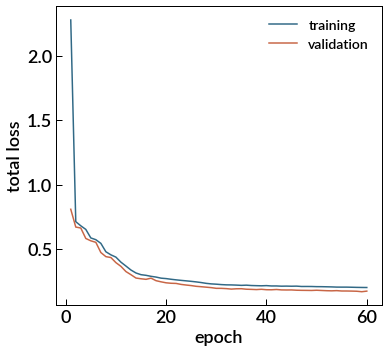

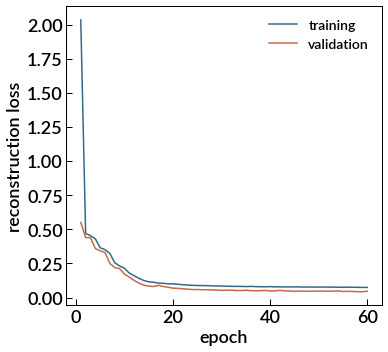

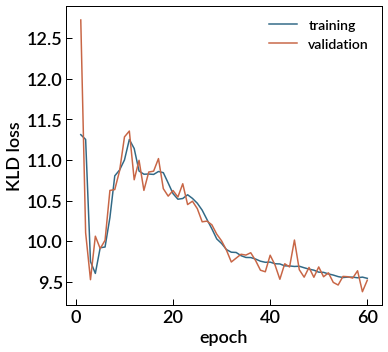

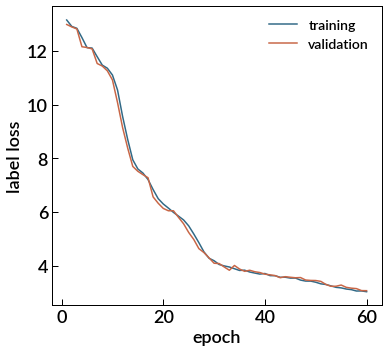

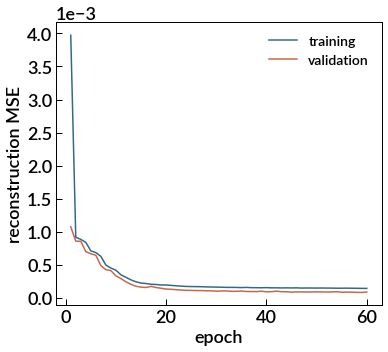

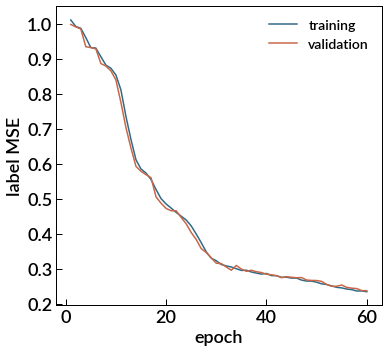

In [12]:
# plot training history
dynamics = torch.load(image_dir + '/model.torch')['dynamics']
plot_history(image_dir, dynamics, logscale=False)

In [12]:
# predict on synthetic data
df = get_predictions(model, data_loaders, d_sets, device, height, width, num_features, kwargs, model_name, z_std_norm,
                     y_ids, scaler)

In [13]:
# predict on experimental data
df_exp = get_predictions_exp(model, x_exp, exp_names, device, height, width, num_features, kwargs, model_name,
                             z_std_norm, y_ids, scaler)

In [14]:
df_exp[['set', 'y_pred']].values

array([['5K',
        array([23.51302098, 21.05888935,  5.79559213, 24.32139557, 18.00905084,
               20.51842055,  0.        ,  0.84411589, 17.87466691,  8.91718357,
                2.40051552,  0.        ,  0.28024636])                         ]],
      dtype=object)

In [15]:
# print predictions of i_th experiment
i = 0
print('experiment:', exp_names[i])
if model_name == 'rvae':
    dict_exp = dict(zip(y_header + ['class'], df_exp.iloc[i]['y_pred']))
    print(dict_exp)
    
elif model_name == 'cvae':
    dict_exp = dict(zip(y_header, df_exp.iloc[i]['z'][:len(y_header)-1]))
    dict_exp['class_prox'] = df_exp.iloc[i]['y_pred'][0]
    print(dict_exp)

else:
    if not z_std_norm:
        dict_exp = dict(zip(y_header, df_exp.iloc[i]['z'][:len(y_header)-1]))
        print(dict_exp)

experiment: CrO20_BiSbTe20/5K
{'dens_sub': 23.513020977262276, 'dens_AFM': 21.058889349350487, 'dens_TI': 5.795592128510022, 'dens_cap': 24.32139556724824, 'dens_ox': 18.00905083521883, 'd_AFM': 20.518420550751838, 'd_iAFM': 0.0, 'd_prox': 0.8441158948971063, 'd_TI': 17.874666908522265, 'd_cap': 8.917183565839784, 'd_ox': 2.400515522485119, 'magn_iAFM': 0.0, 'magn_prox': 0.2802463613377513}


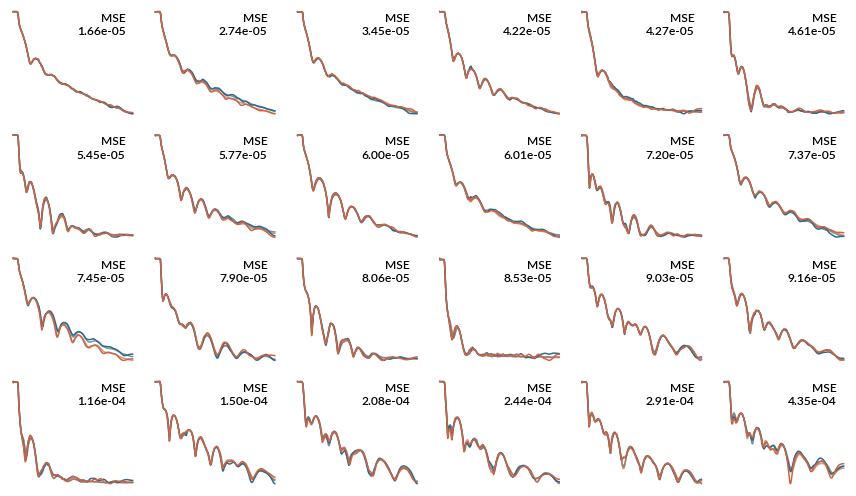

In [17]:
# plot example reconstructions
plot_decoded(image_dir, np.stack(df.loc[df['set']=='test', 'x_pred'].values),
             np.stack(df.loc[df['set']=='test', 'x_true'].values),
             np.stack(df.loc[df['set']=='test', 'x_mse'].values), 'test')

In [46]:
# to reload modules without restarting kernel (optional)
from importlib import reload
import sys
reload(sys.modules['pnr_utils'])
reload(sys.modules['pnr_models'])
from pnr_utils import *
from pnr_models import *

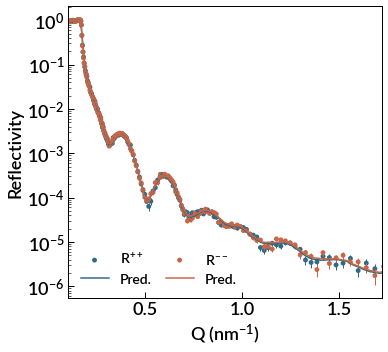

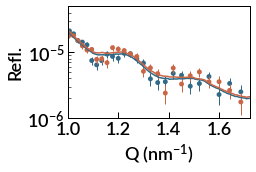

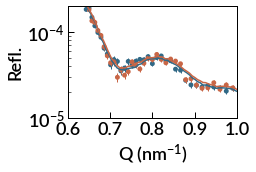

In [44]:
# plot reconstructed experiment
plot_decoded_exp(image_dir, np.stack(df_exp['x_pred'].values), exp_names, q, x_moms)

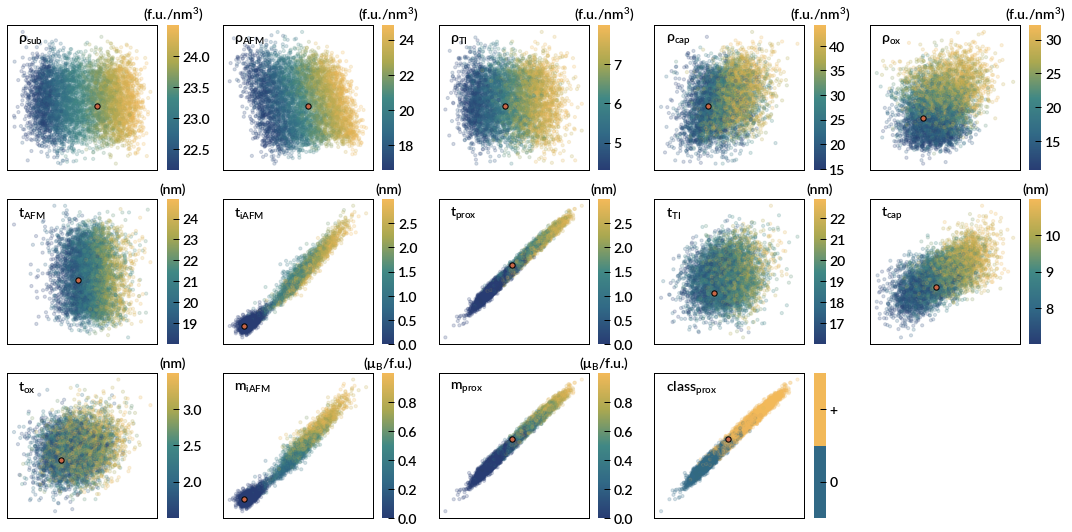

In [46]:
# visualize separability of latent space
plot_latent_representation(image_dir, np.stack(df.loc[df['set']=='test', 'z'].values),
                           np.stack(df.loc[df['set']=='test', 'y_true'].values),
                           y_ids, y_labels, y_units, 'encoded_test', np.stack(df_exp['z'].values), exp_names, mode=2)

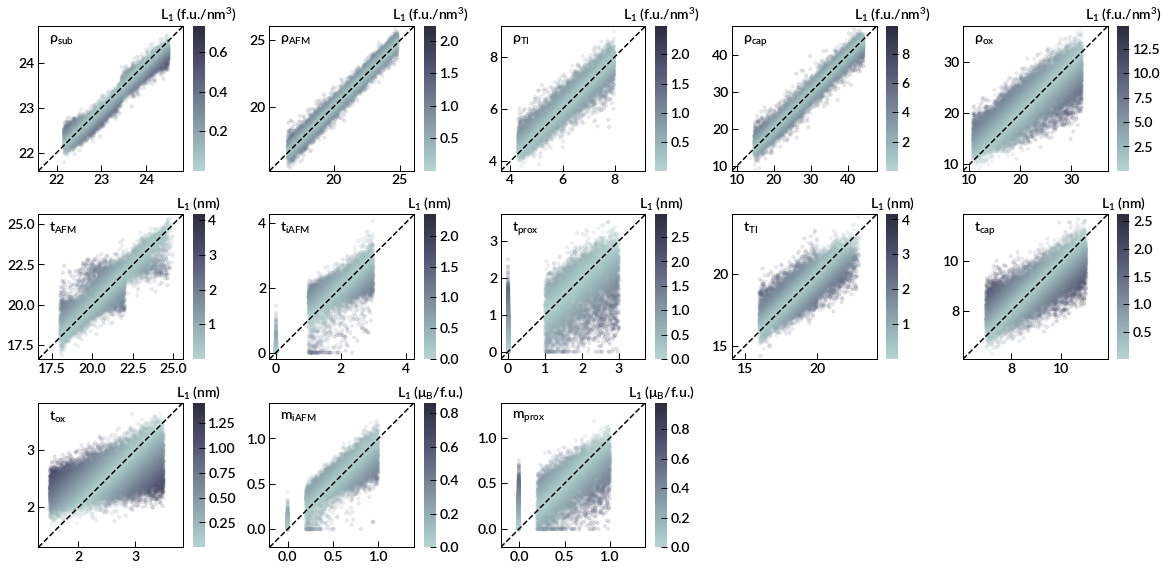

In [28]:
# plot regressor performance
if model_name == 'rvae':
    plot_predicted(image_dir, np.stack(df.loc[df['set']=='test', 'y_pred'].values),
               np.stack(df.loc[df['set']=='test', 'y_true'].values),
               np.stack(df.loc[df['set']=='test', 'y_err'].values), y_ids, y_labels, y_units)

else:
    if not z_std_norm:
        plot_predicted(image_dir, np.stack(df.loc[df['set']=='test', 'z'].values),
                       np.stack(df.loc[df['set']=='test', 'y_true'].values),
                       np.stack(df.loc[df['set']=='test', 'z_mse'].values), y_ids, y_labels, y_units)

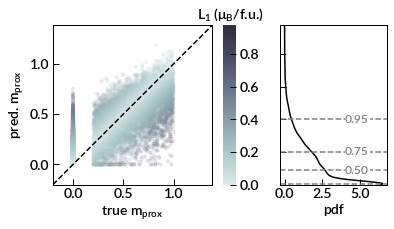

In [47]:
# plot regressor performance per property
if model_name == 'rvae':
    y_name = 'magn_prox'
    plot_predicted_property(image_dir, np.stack(df.loc[df['set']=='test', 'y_pred'].values),
                            np.stack(df.loc[df['set']=='test', 'y_true'].values),
                            np.stack(df.loc[df['set']=='test', 'y_err'].values), y_name,
                            y_header, y_ids, y_labels, y_units)

else:
    if not z_std_norm:
        plot_predicted(image_dir, np.stack(df.loc[df['set']=='test', 'z'].values),
                       np.stack(df.loc[df['set']=='test', 'y_true'].values),
                       np.stack(df.loc[df['set']=='test', 'z_mse'].values), y_ids, y_labels, y_units)

In [62]:
print(dict(zip(y_header, y_ids)))

{'dens_sub': 0, 'dens_TI': 1, 'dens_FM': 2, 'dens_cap': 3, 'd_TI': 5, 'd_prox': 6, 'd_FM': 7, 'd_cap': 8, 'magn_prox': 16, 'magn_FM': 17, 'class_prox': 19}


In [142]:
# find optimal threshold and plot classifier performance
if model_name == 'cvae':
    fpr, tpr, roc_auc, th = get_roc(df, d_sets)
    tpr0, fpr0, th = get_optimal_threshold(fpr[1], tpr[1], th[1])

    plot_roc(image_dir, fpr, tpr, roc_auc, [tpr0, fpr0, th])
    plot_precision_recall_f1(image_dir, df, d_sets, th)

### Evaluate all models

- Compile the training history and experiment predictions on all model repetitions.


- Plot the training history statistics.


- Plot classification statistics on experimental data.

In [13]:
# predict on all models to compute statistics
dynamics = []
#for r in range(reps):
for r in range(reps):
    image_dir = model_dir + '/model_' + str(r)
    model, _, _ = init_model(model_name, height, width, num_features, kwargs, device, scaler=torch_scaler)
    model.load_state_dict(torch.load(image_dir + '/model.torch')['state'])
    
    # plot training history
    dynamics += [torch.load(image_dir + '/model.torch')['dynamics']]
    
    # get optimal threshold
    if model_name == 'cvae':
        
        # predict on synthetic data
        df = get_predictions(model, data_loaders, d_sets, device, height, width, num_features, kwargs, model_name,
                             z_std_norm, y_ids, scaler)
    
        fpr, tpr, _, th = get_roc(df, d_sets)
        _, _, th = get_optimal_threshold(fpr[1], tpr[1], th[1])
        
    # predict on experimental data
    if r > 0:
        df = get_predictions_exp(model, x_exp, exp_names, device, height, width, num_features, kwargs, model_name,
                                 z_std_norm, y_ids, scaler)
        df['model'] = r
        if model_name == 'cvae': df['th'] = th
        df_exp = df_exp.append(df, ignore_index=True)
        
    else:
        df_exp = get_predictions_exp(model, x_exp, exp_names, device, height, width, num_features, kwargs, model_name,
                                     z_std_norm, y_ids, scaler)
        df_exp['model'] = r
        if model_name == 'cvae': df_exp['th'] = th

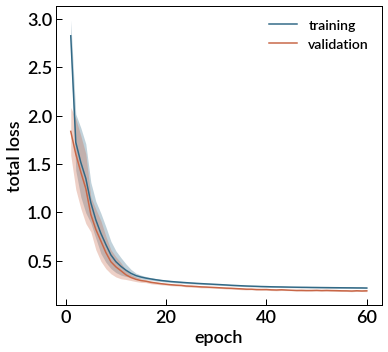

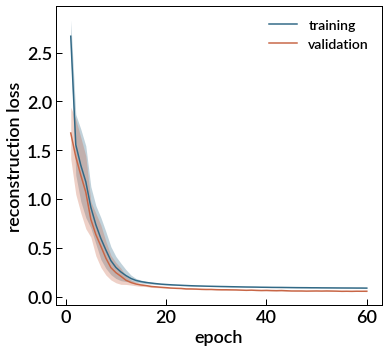

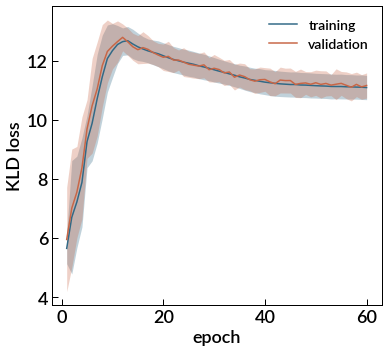

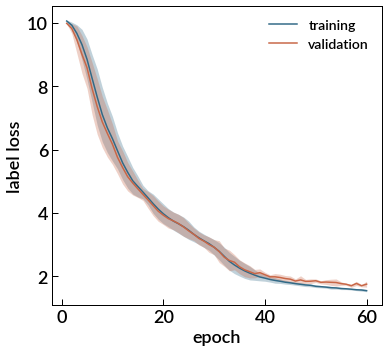

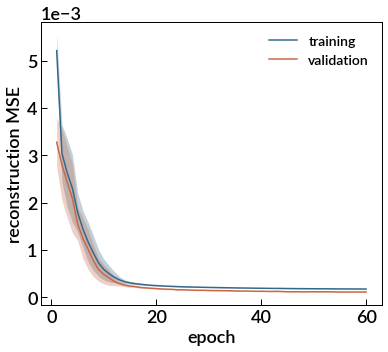

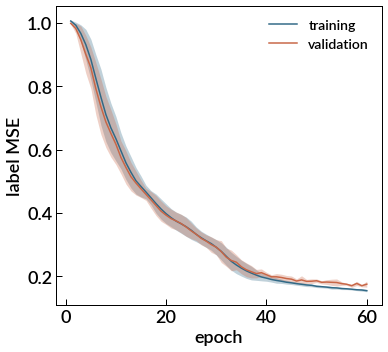

In [14]:
# plot training history statistics
plot_history_statistics(model_dir, dynamics, logscale=False)

In [15]:
# plot class statistics on experimental sample
if model_name == 'cvae':
    plot_class_exp_statistics(model_dir, df_exp, reps)

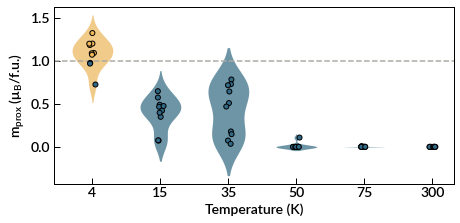

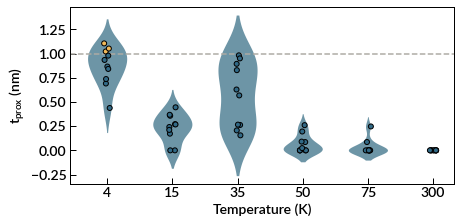

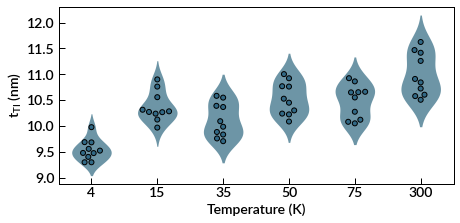

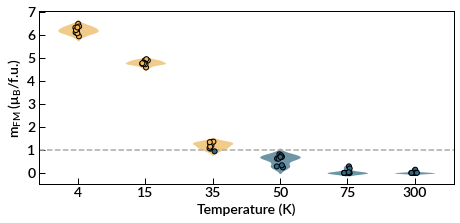

In [20]:
if not z_std_norm:
    plot_exp_statistics(model_dir, df_exp, reps, 'magn_prox', y_header, y_labels, y_units, y_th=1)
    plot_exp_statistics(model_dir, df_exp, reps, 'd_prox', y_header, y_labels, y_units, y_th=1)
    plot_exp_statistics(model_dir, df_exp, reps, 'd_TI', y_header, y_labels, y_units)
    plot_exp_statistics(model_dir, df_exp, reps, 'magn_FM', y_header, y_labels, y_units, y_th=1)